In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def f(abscissa):
    return 2 * abscissa ** 2 + abscissa + 1

In [3]:
NUM_EXAMPLES = 1000

In [4]:
data_x = np.linspace(-2, 2, NUM_EXAMPLES)
data_x = tf.cast(data_x, tf.float32)
noise = tf.random.normal(shape=[NUM_EXAMPLES])
data_y_true = f(data_x)
data_y = data_y_true + noise

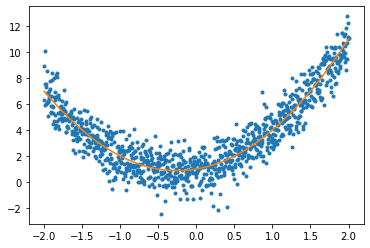

In [5]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.show()

In [6]:
initializer = tf.keras.initializers.GlorotUniform()

class CustomDense(tf.keras.layers.Layer):
    out_features: int
    activation: Callable[[tf.Tensor], tf.Tensor]
    weights_local: tf.Variable
    biases_local: tf.Variable

    def __init__(self, out_features: int, activation: Callable[[tf.Tensor], tf.Tensor] = tf.identity, **kwargs):
        super().__init__(**kwargs)
        self.out_features = out_features
        self.activation = activation

    def build(self, input_shape):
        self.weights_local = tf.Variable(initializer(shape=(input_shape[-1], self.out_features)), name='weights_local')
        self.biases_local = tf.Variable(tf.zeros([self.out_features]), name='biases_local')

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self.activation(tf.matmul(inputs, self.weights_local) + self.biases_local)


In [7]:
input_layer = tf.keras.Input(shape=[1, ])
layer = CustomDense(32, activation=tf.nn.relu)(input_layer)
layer = CustomDense(32, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(16, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(8, activation=tf.nn.relu)(layer)
layer = CustomDense(4)(layer)
layer = CustomDense(2)(layer)
layer = CustomDense(1)(layer)

model = tf.keras.Model(inputs=input_layer, outputs=layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 custom_dense (CustomDense)  (None, 32)                64        
                                                                 
 custom_dense_1 (CustomDense  (None, 32)               1056      
 )                                                               
                                                                 
 custom_dense_2 (CustomDense  (None, 16)               528       
 )                                                               
                                                                 
 custom_dense_3 (CustomDense  (None, 16)               272       
 )                                                               
                                                             

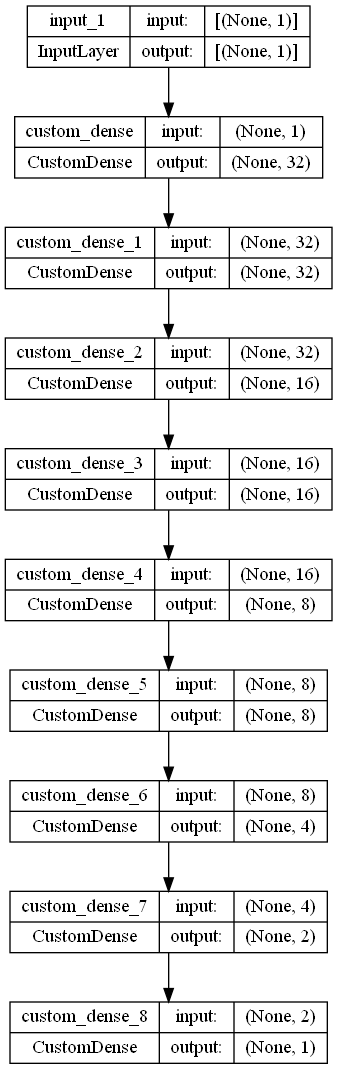

In [8]:
tf.keras.utils.plot_model(model, '../../output/my_first_model_with_shape_info.png', show_shapes=True)

In [94]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.mean_squared_error,
)

In [95]:
model.fit(data_x, data_y, epochs=500, batch_size=NUM_EXAMPLES)

Epoch 1/500
1/1 [==============================] - 0s 408ms/step - loss: 22.1525
Epoch 2/500
1/1 [==============================] - 0s 13ms/step - loss: 18.4403
Epoch 3/500
1/1 [==============================] - 0s 12ms/step - loss: 15.7165
Epoch 4/500
1/1 [==============================] - 0s 10ms/step - loss: 13.1982
Epoch 5/500
1/1 [==============================] - 0s 11ms/step - loss: 10.8671
Epoch 6/500
1/1 [==============================] - 0s 11ms/step - loss: 8.9358
Epoch 7/500
1/1 [==============================] - 0s 11ms/step - loss: 7.6237
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 6.9363
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 6.5767
Epoch 10/500
1/1 [==============================] - 0s 10ms/step - loss: 6.2937
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 5.9803
Epoch 12/500
1/1 [==============================] - 0s 12ms/step - loss: 5.6326
Epoch 13/500
1/1 [=========================

In [87]:
prediction_result = model.predict(data_x, batch_size=NUM_EXAMPLES).reshape((-1,))
prediction_result

1/1 [==============================] - 0s 72ms/step


array([6.082072 , 6.068456 , 6.0545936, 6.04061  , 6.026617 , 6.01241  ,
       5.9977727, 5.9831343, 5.9684973, 5.95386  , 5.939222 , 5.9245844,
       5.9099474, 5.895309 , 5.8803563, 5.862463 , 5.844253 , 5.8260427,
       5.807834 , 5.7896237, 5.771414 , 5.753204 , 5.734995 , 5.7167854,
       5.6985755, 5.680366 , 5.662156 , 5.643946 , 5.6257358, 5.6075263,
       5.589317 , 5.571107 , 5.5528975, 5.5346875, 5.516478 , 5.4982677,
       5.480058 , 5.4618487, 5.443639 , 5.425429 , 5.4072204, 5.38901  ,
       5.3708   , 5.35259  , 5.3343806, 5.3161707, 5.2979617, 5.2797513,
       5.261543 , 5.2433324, 5.225123 , 5.206913 , 5.188703 , 5.1704936,
       5.152283 , 5.1340747, 5.115864 , 5.0976553, 5.0794444, 5.061235 ,
       5.0430255, 5.024816 , 5.0066066, 4.988396 , 4.9701867, 4.9519763,
       4.933767 , 4.9155574, 4.897348 , 4.8791385, 4.8609285, 4.842719 ,
       4.8245096, 4.8062997, 4.78809  , 4.769879 , 4.7516704, 4.73346  ,
       4.71525  , 4.697041 , 4.6788316, 4.660621 , 

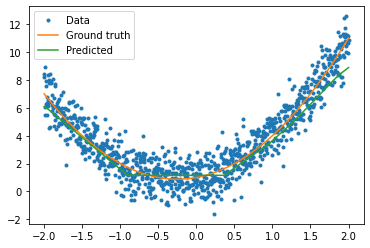

In [88]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.plot(data_x, prediction_result, label='Predicted')
plt.legend()
plt.show()